In [85]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [114]:
%run ImageDataLoader.ipynb
%run ImageProcessor.ipynb
%run DataExplorer.ipynb
%run DatasetStatistics.ipynb
%run DuplicateDetector.ipynb
%run OversampledDataset.ipynb
%run BatchVisualizer.ipynb

In [87]:
DATA_ROOT = "./data"
TRAIN_DIR = "./data/Training"
TEST_DIR = "./data/Testing"
BATCH_SIZE = 64
IMAGE_SIZE = (224, 224)
VAL_SPLIT = 0.15

In [88]:
device = (
    torch.accelerator.current_accelerator().type
    if torch.accelerator.is_available()
    else "cpu"
)
print(f"Using {device} device")
print(f"Accelerator name: {torch.cuda.get_device_name(device)}")

Using cuda device
Accelerator name: NVIDIA GeForce RTX 5070 Ti


In [89]:
loader = ImageDataLoader(TRAIN_DIR, TEST_DIR)
all_files = loader.load_all_images()

print(f"Successfully loaded {len(all_files)} images")

Successfully loaded 3264 images



Checking 3264 files for duplicates...


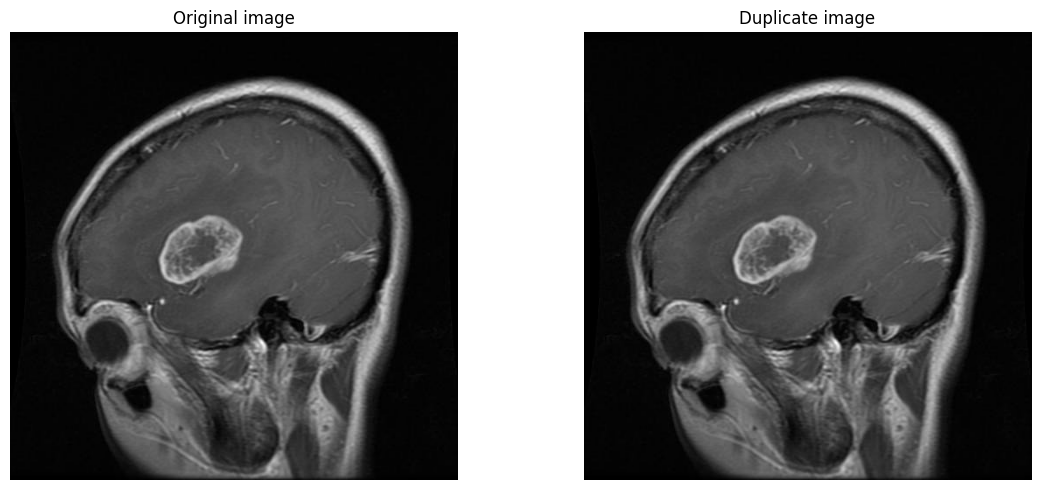

KeyboardInterrupt: 

In [35]:
duplicate_detector = DuplicateDetector(all_files)
duplicate_detector.detect_duplicates()

if len(duplicate_detector.duplicates) > 0:  # If duplicate files are present
    # duplicate_detector.remove_duplicates_from_disk()  # Removing duplicates entirely from disk to make every next call faster
    all_files = duplicate_detector.get_unique_files()  # Cleaning list with file paths

In [90]:
loader.print_dataset_class_count()

Training folder details:
	glioma_tumor: 826 images
	meningioma_tumor: 822 images
	no_tumor: 395 images
	pituitary_tumor: 827 images
Testing folder details:
	glioma_tumor: 100 images
	meningioma_tumor: 115 images
	no_tumor: 105 images
	pituitary_tumor: 74 images



Loading 3264 images and converting to grayscale...
  Progress: 1/3264 images
  Progress: 500/3264 images
  Progress: 1000/3264 images
  Progress: 1500/3264 images
  Progress: 2000/3264 images
  Progress: 2500/3264 images
  Progress: 3000/3264 images
Images loaded


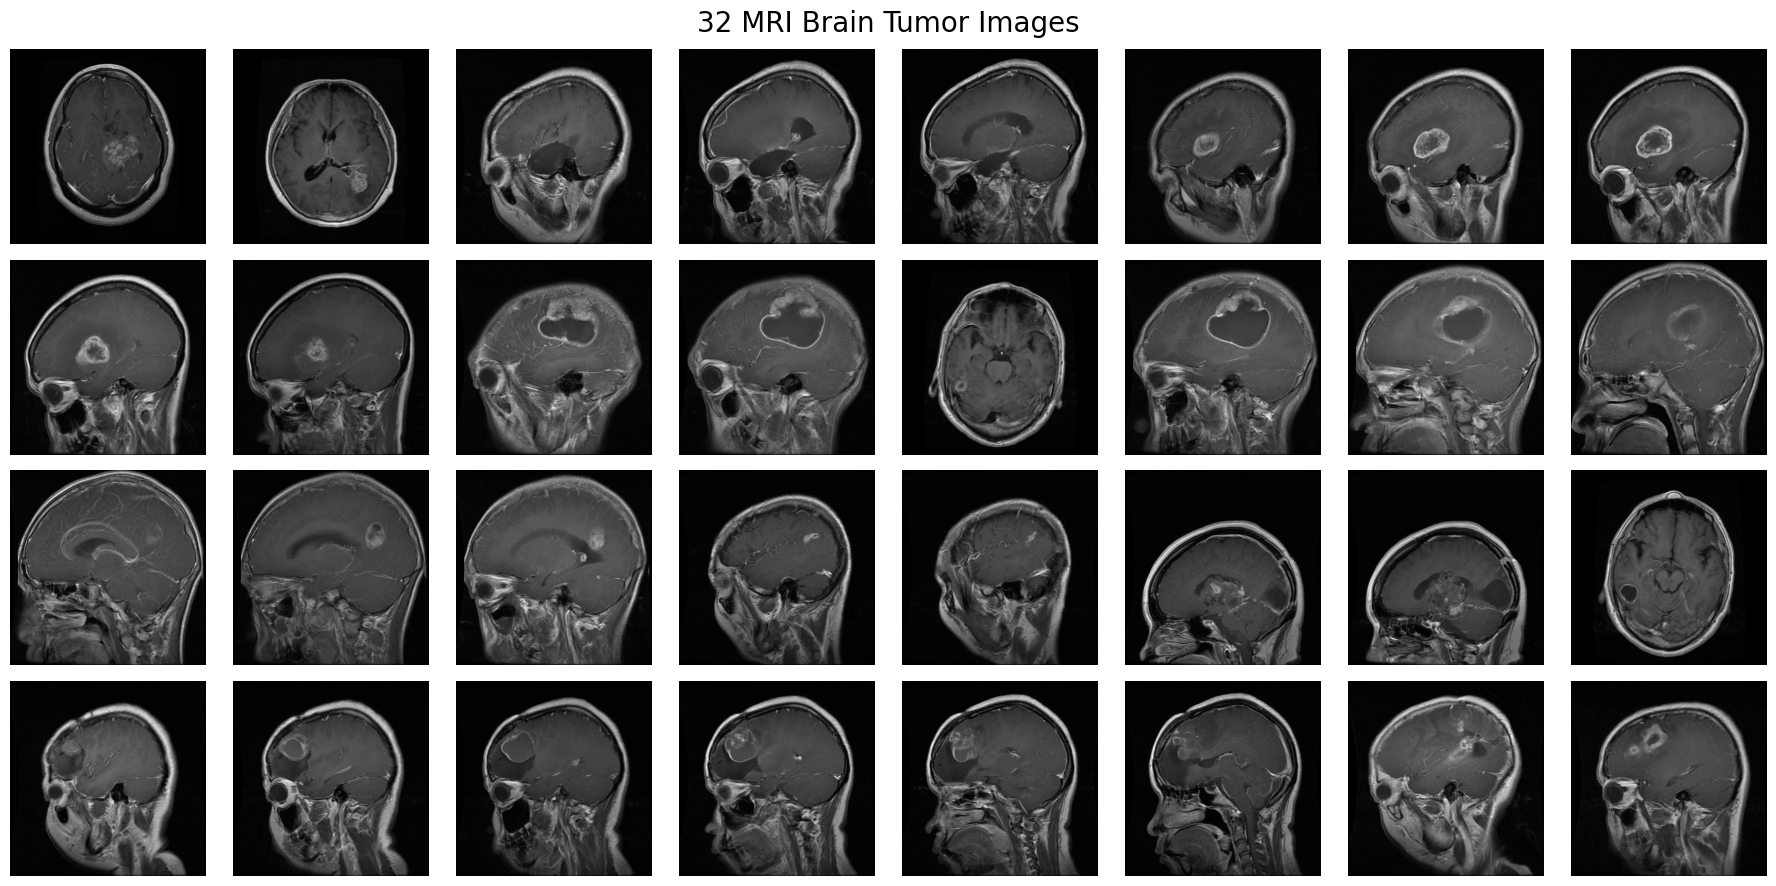

In [91]:
processor = ImageProcessor(all_files)

processor.load_grayscale_images()
processor.display_image_grid(batch_size=32, figsize=(18, 9), images_per_row=8)

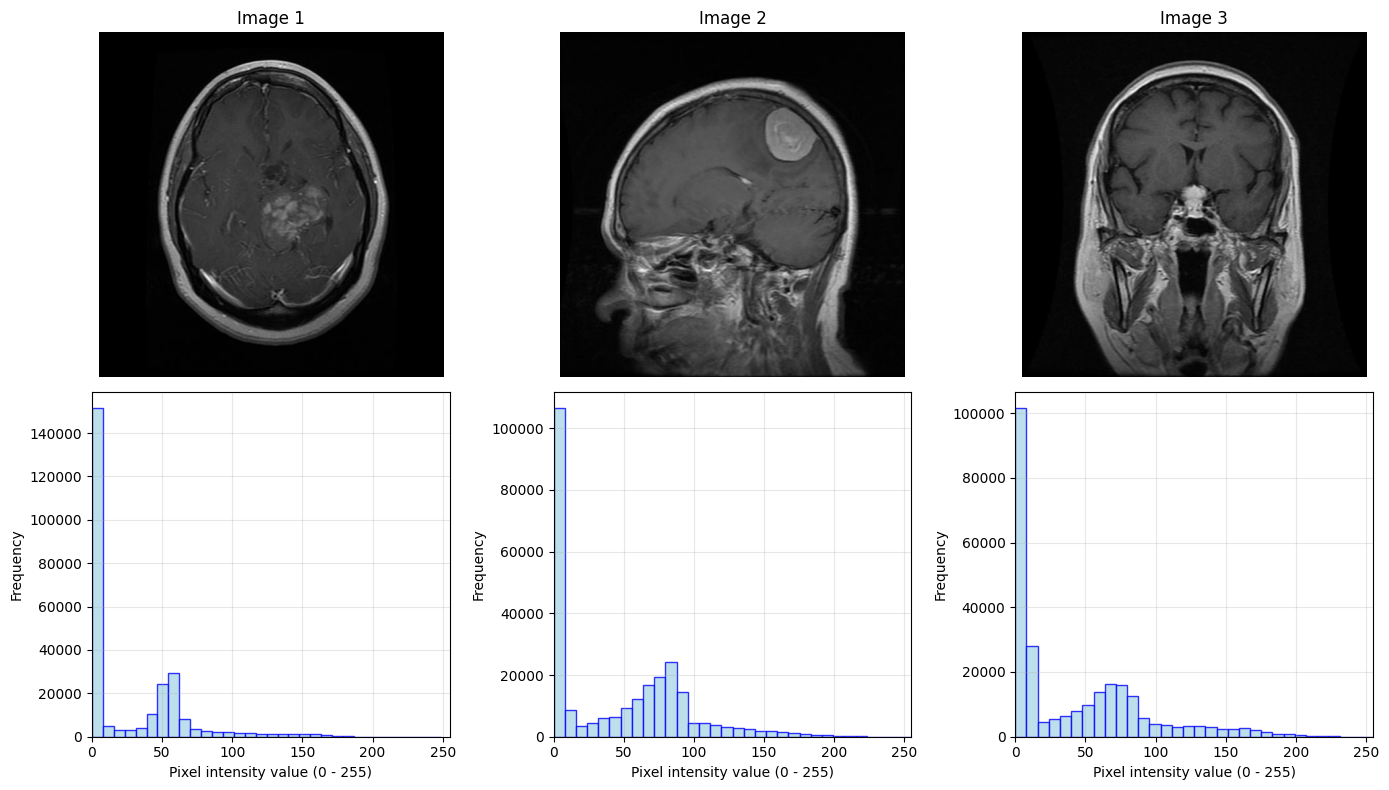

In [92]:
explorator = DataExplorer(all_files)
explorator.retrieve_sample_of_images(
    [0, len(all_files) // 2, -1]
)  # First, middle and last image

explorator.plot_histogram()

In [93]:
stats = DatasetStatistics(processor.gray_images)

stats.compute_stats()
stats.print_stats()

MEAN, STD = stats.get_normalized_values()

Dataset Statistics:
	Mean: 47.90
	Standard Deviation: 48.06
	Minimum: 0.00
	Maximum: 255.00
	Median: 37.00


In [94]:
train_transform = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(12),
        transforms.ColorJitter(brightness=0.15, contrast=0.15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[MEAN] * 3, std=[STD] * 3),
    ]
)

In [95]:
test_transform = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[MEAN] * 3, std=[STD] * 3),
    ]
)

In [96]:
trainset = OversampledDataset(TRAIN_DIR, transform=train_transform)
testset = datasets.ImageFolder(TEST_DIR, transform=test_transform)

print()
trainset.print_class_distribution()

print()
print(f"Training samples: {len(trainset)}")
print(f"Test samples: {len(testset)}")
print(f"Classes: {trainset.classes}")

Before oversampling: 2870
After oversampling: 3265

Class distribution after oversampling:
  glioma_tumor: 826 images
  meningioma_tumor: 822 images
  no_tumor: 790 images
  pituitary_tumor: 827 images

Training samples: 3265
Test samples: 394
Classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [97]:
train_size = int((1 - VAL_SPLIT) * len(trainset))
val_size = len(trainset) - train_size

print(
    f"Validation set size: {val_size} images\n \
      Train set size: {train_size} images"
)

Validation set size: 490 images
       Train set size: 2775 images


In [98]:
trainset, valset = random_split(
    trainset, [train_size, val_size], generator=torch.Generator().manual_seed(42)
)

print(f"Train: {len(trainset)}, Validation: {len(valset)}")

Train: 2775, Validation: 490


In [99]:
train_dl = DataLoader(trainset, BATCH_SIZE, shuffle=True, num_workers=0)
val_dl = DataLoader(valset, BATCH_SIZE, shuffle=False, num_workers=0)
test_dl = DataLoader(testset, BATCH_SIZE, shuffle=False, num_workers=0)

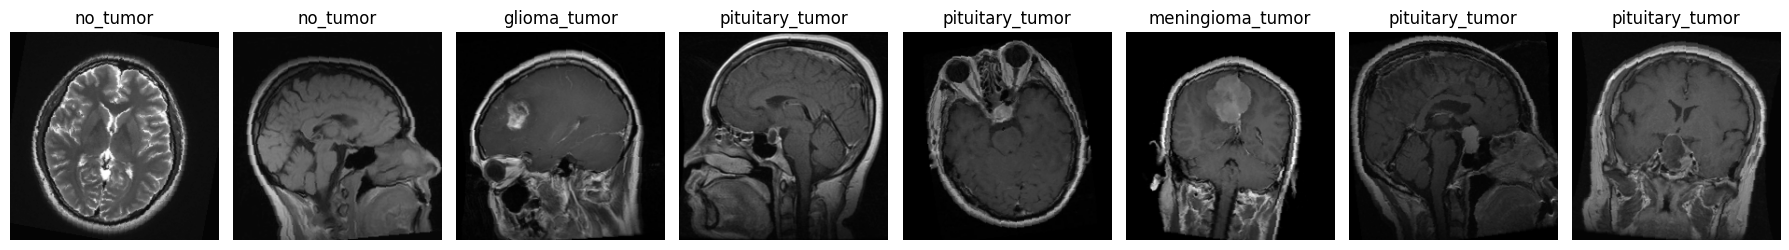

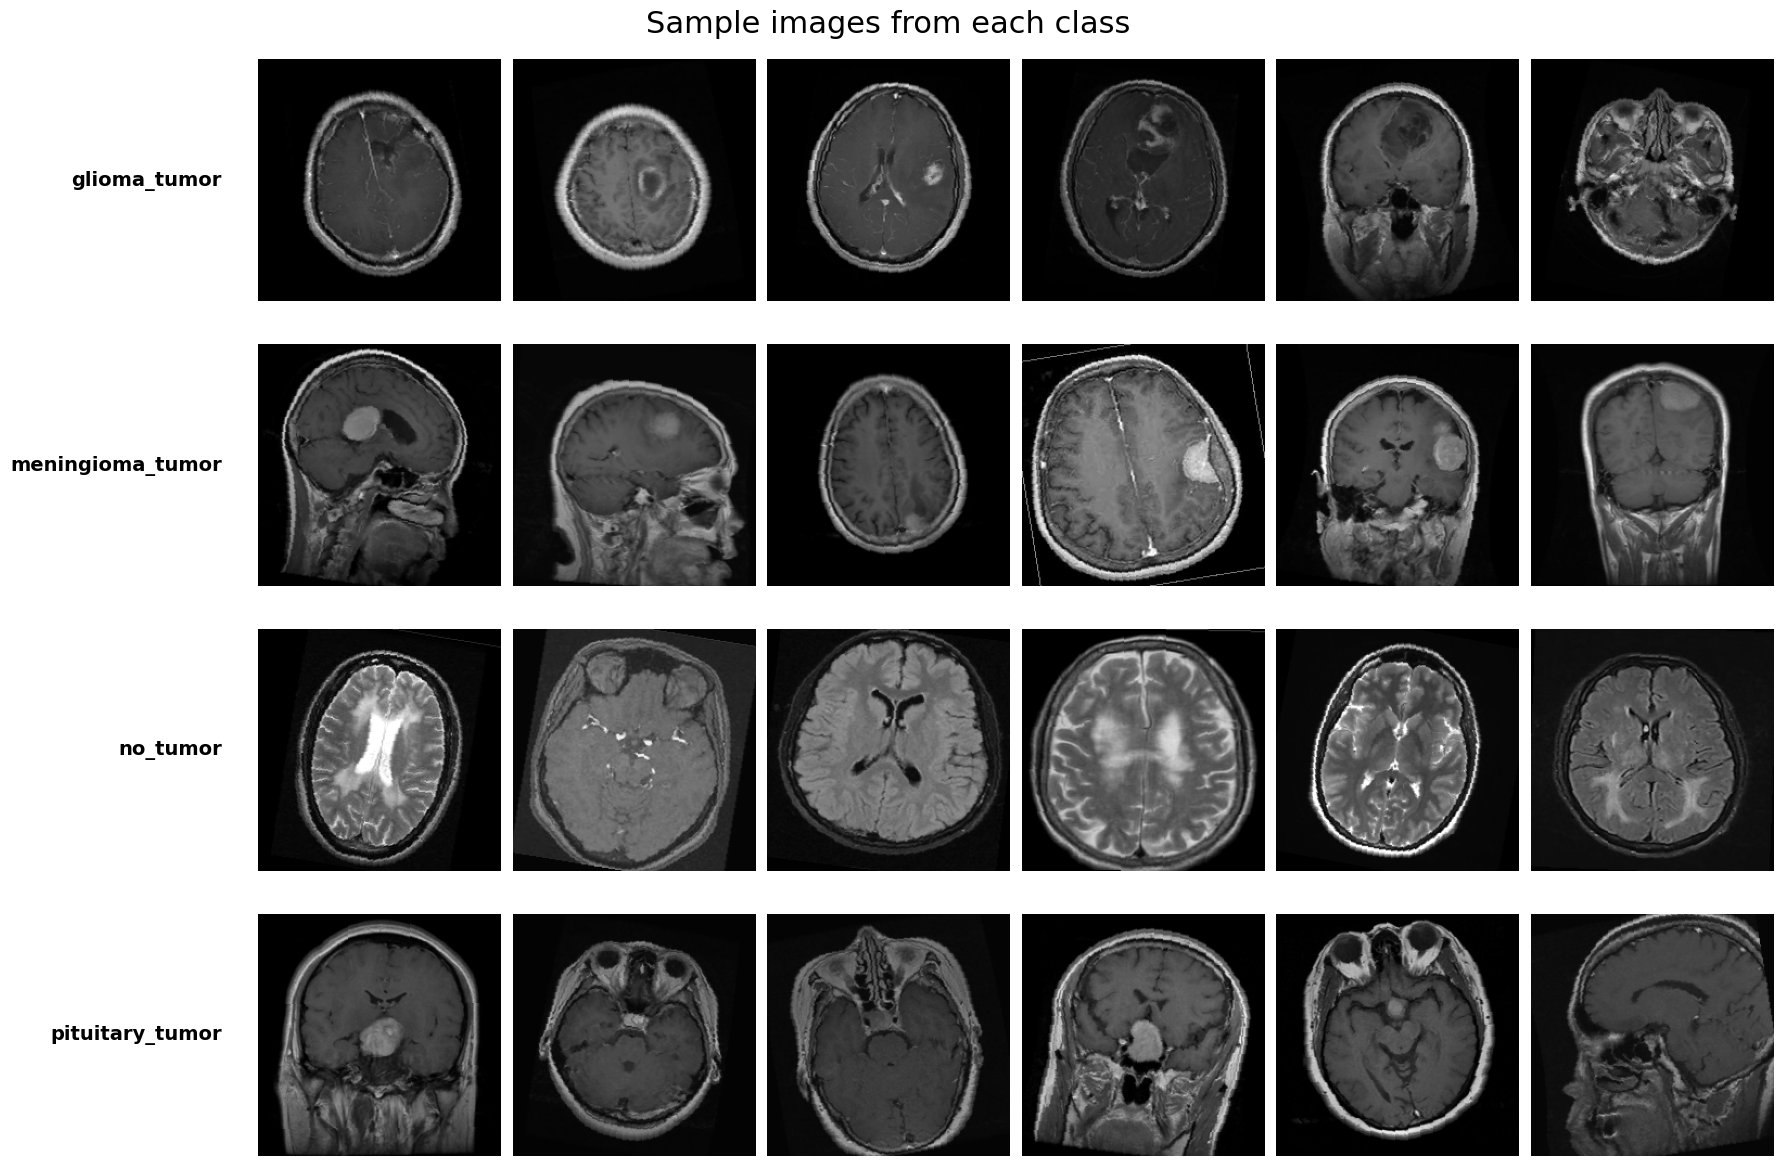

In [115]:
visualizer = BatchVisualizer(trainset.dataset.classes, mean=[MEAN] * 3, std=[STD] * 3)

visualizer.visualize_batch(train_dl)
visualizer.visualize_classes(train_dl, 6)